##### Author contributions
Please fill out for each of the following parts who contributed to what:
- Conceived ideas: Nienke, Miriam, Ajinkya, Roel
- Performed math exercises: - (there are no math exercises this time)
- Performed programming exercises: Ajinkya, Nienke, Miriam, Roel
- Contributed to the overall final assignment: Miriam, Nienke, Roel, Ajinkya

# Chapter 6
## Deep learning


    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Brightspace before the deadline (see Brightspace).

Learning goals:
1. Get familiar with a state-of-the-art module for deep learning
1. Implement and run a multilayer neural network in PyTorch
1. Understand convolution
1. Implement and run a convolutional neural network in PyTorch

In [1]:
# import libraries
import numpy as np
import scipy.io as sio
from scipy import signal as ss

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

It might occur that the above imports throw an error, saying `torch` is an unknown module. If so, you have not yet installed `pytorch` properly. Do so by opening a terminal and installing it by calling `conda install pytorch torchvision -c pytorch` (i.e., see https://pytorch.org/get-started/locally/).

When working on a state-of-the-art neural network project you will rely on one of the various neural network frameworks that are available, instead of implementing core functionality by yourself. In this exercise you will work on implementing an MLP and a CNN in the PyTorch framework. 

To get familiar with PyTorch, read the tutorial at https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html. It is a good introduction to PyTorch including setting up data, defining a model, and training a model. 

### Exercise 1: MNIST data (1 point)
We will use the MNIST dataset (handwritten digets) for this assignment. The dataset is a very standard and commonly used benchmark dataset. In this assignment, we will only work with a training and validation dataset. Normally, one would also have a testing dataset, but we will ignore this in this assignment.
1. Load the *MNIST* dataset. Use a training and a validation dataset.
1. Define training and validation data iterators and use a specific batchsize.
1. Inspect the training and validation data by printing (1) the amount of samples in each set and (2) the shape of a data sample.
1. Inspect the training and validation data by plotting some samples (as images).

### Solution 1

In [2]:
# global parameters
BATCH_SIZE = 256
TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [3]:
# download and load train and validation datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=TRANSFORM, download=True)
valid_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=TRANSFORM, download=True)

# define data iterators
train_data = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle=True)
valid_data = torch.utils.data.DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [4]:
# inspect datasets
examples = enumerate(train_data)
batch_idx, (example_data, example_targets) = next(examples)
print("Training Dataset => Number of samples: {} | Shape of data sample: {}".format(example_data.shape[0], 
                                                                                    example_data.shape[1:]))

examples = enumerate(valid_data)
batch_idx, (example_data, example_targets) = next(examples)
print("Validation Dataset => Number of samples: {} | Shape of data sample: {}".format(example_data.shape[0], 
                                                                                      example_data.shape[1:]))

Training Dataset => Number of samples: 256 | Shape of data sample: torch.Size([1, 28, 28])
Validation Dataset => Number of samples: 256 | Shape of data sample: torch.Size([1, 28, 28])


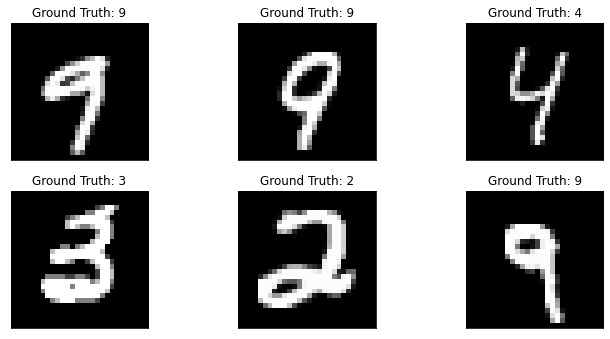

In [5]:
# visualize datasets
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

### Exercise 2: Training a model (3 points)
Define a function `train_model` with input arguments `model`, `train_data`, `valid_data`, `optimizer`, `criterion`, and `n_epochs`, and output arguments `model`, `train_loss`, `valid_loss`, `train_accuracy`, `valid_accuracy`. We will use this function to train both a MLP as well as a CNN. It therefore has to be generic to any type of model, optimizer, or loss function. The function:
1. Loops over `n_epoch` epochs.
1. Loops over minibatches of both training data `train_data` as well as validation data `valid_data`.
1. Trains the model using the loss function defined by `criterion` and optimizer `optimizer` using the training data.
1. Computes and saves losses for both training and validation data per epoch in `train_loss` and `valid_loss`.
1. Computes and saves accuracies for both training and validation data per epoch in `train_accuracy` and `valid_accuracy`.

### Solution 2

In [6]:
def train_model(model, train_data, valid_data, optimizer, criterion, n_epochs):
    """
    @description:
        function to train a PyTorch Model
    @arguments:
        model (torch) - model to be trained
        train_data (torch) - training dataset loader
        valid_data (torch) - validation dataset loader
        optimizer (torch) - optimization function
        criterion (torch) - loss function
        n_epochs (int) - number of training epochs (default = 200)
        transform (torch) - input transformation
    @returns:
        model (torch) - trained model
        train_loss (np array) - training loss over epochs
        valid_loss (np array) - validation loss over epochs
        train_accuracy (np array) - training accuracy over epochs
        valid_accuracy (np array) - validation accuracy over epochs
    """
    train_loss = np.zeros(n_epochs) # buffer for training loss over epochs
    valid_loss = np.zeros(n_epochs) # buffer for validation loss over epochs
    
    train_accuracy = np.zeros(n_epochs) # buffer for training accuracy over epochs
    valid_accuracy = np.zeros(n_epochs) # buffer for validation accuracy over epochs

    for epoch in range (n_epochs):
        
        # set model in training mode
        model.train()
        for images, labels in train_data:
            # zeroes the gradient buffers of all parameters
            optimizer.zero_grad()
            # forward function
            outputs = model(images)
            # compute loss
            loss = criterion(outputs, labels)
            # save loss
            train_loss[epoch] = loss
            # compute and save accuracy
            _,outputs = torch.max(outputs,1)
            train_accuracy[epoch] = (outputs == labels).sum().float()/images.shape[0]
            # backpropagation function
            loss.backward()
            # optimize
            optimizer.step()
        
        # set model in training mode
        model.eval()
        for images, labels in valid_data:
            # forward function
            with torch.no_grad():
                outputs = model(images)
            # compute loss
            valid_loss[epoch] = criterion(outputs, labels)
            # compute accuracy
            _,outputs = torch.max(outputs,1)
            valid_accuracy[epoch] = (outputs == labels).sum().float()/images.shape[0]
        
        # print training log
        print("epoch {}: train_loss: {:.3f} | train_acc: {:.3f} | val_loss: {:.3f} | val_acc: {:.3f}".format(epoch+1, 
                                                                                               train_loss[epoch], 
                                                                                               train_accuracy[epoch], 
                                                                                               valid_loss[epoch], 
                                                                                               valid_accuracy[epoch]))

    return model, train_loss, valid_loss, train_accuracy, valid_accuracy       

### Exercise 3: Setup an MLP (1 point)
As a first model, setup a multilayer perceptron:
1. with two linear (i.e., fully connected) weight layers
1. with a hidden layer of 16 ReLU units

### Solution 3

In [7]:
class MLP(nn.Module):
    """
    PyTorch Implementation of Multi-Layer Perceptron
    """
    def __init__(self, in_size, out_size, n_hidden):
        """
        @description:
            Initial Network Setup
        @arguments:
            in_size (int) - input layer size
            out_size (int) - output layer size
            n_hidden (int) - number of hidden units
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_size,n_hidden) # first layer
        self.fc2 = nn.Linear(n_hidden, out_size) # second layer
        self.relu = nn.ReLU() # reLU activation
    
    def forward(self, x):
        """
        @description:
            Feed-forward function
        @arguments:
            x (tensor) - input tensor
        @returns:
            y (tensor) - output tensor
        """
        x = x.view(x.size(0), -1) # reshape x
        h = self.relu(self.fc1(x)) # hidden layer
        y = self.relu(self.fc2(h)) # output layer
        return y        

### Exercise 4: Train the MLP (1 point) 
Train the MLP using the MNIST dataset:
1. As optimizer use SGD with a learning rate of 0.001 and momentum of 0.9.
1. As loss function use the cross-entropy loss.
1. Train the MLP in 20 epochs.
1. Plot the training and validation losses as a function of epochs.
1. Plot the training and validation accuracies as a function of epochs.

### Solution 4

In [8]:
LR = 0.001
MOMENTUM = 0.9
IN_SIZE = 784 # 28x28 images
OUT_SIZE = 10 # 0-9 digits
N_HIDDEN = 16 # 16 hidden reLU units
N_EPOCHS = 20 # 20 epochs

In [9]:
# define model
model = MLP(IN_SIZE, OUT_SIZE, N_HIDDEN)
# define optimizer
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
# define criterion (loss function)
criterion = nn.CrossEntropyLoss()

In [10]:
# train model
model, train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, train_data, valid_data, 
                                                                            optimizer, criterion, N_EPOCHS)

epoch 1: train_loss: 1.769 | train_acc: 0.510 | val_loss: 1.475 | val_acc: 0.688
epoch 2: train_loss: 1.434 | train_acc: 0.562 | val_loss: 1.667 | val_acc: 0.438
epoch 3: train_loss: 1.516 | train_acc: 0.500 | val_loss: 1.107 | val_acc: 0.625
epoch 4: train_loss: 1.307 | train_acc: 0.583 | val_loss: 1.079 | val_acc: 0.688
epoch 5: train_loss: 1.282 | train_acc: 0.583 | val_loss: 1.575 | val_acc: 0.438
epoch 6: train_loss: 1.158 | train_acc: 0.635 | val_loss: 0.992 | val_acc: 0.688
epoch 7: train_loss: 0.995 | train_acc: 0.646 | val_loss: 1.394 | val_acc: 0.562
epoch 8: train_loss: 1.226 | train_acc: 0.552 | val_loss: 0.905 | val_acc: 0.688
epoch 9: train_loss: 1.005 | train_acc: 0.656 | val_loss: 0.755 | val_acc: 0.688
epoch 10: train_loss: 1.064 | train_acc: 0.635 | val_loss: 1.067 | val_acc: 0.562
epoch 11: train_loss: 1.185 | train_acc: 0.573 | val_loss: 1.520 | val_acc: 0.438
epoch 12: train_loss: 0.893 | train_acc: 0.688 | val_loss: 1.558 | val_acc: 0.625
epoch 13: train_loss: 0.8

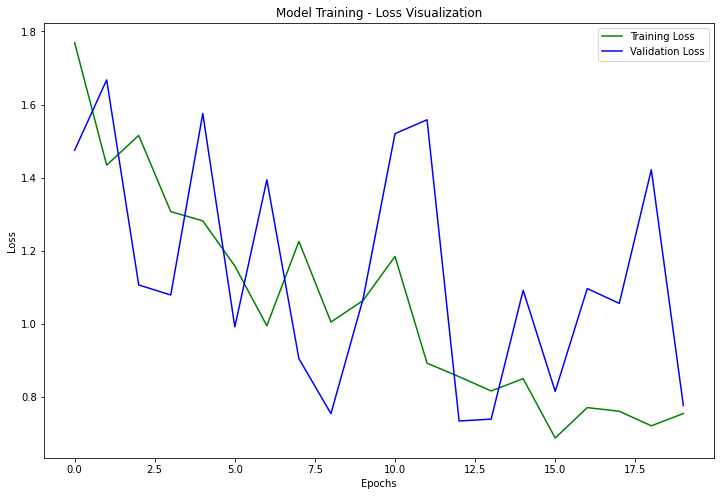

In [11]:
# plot losses
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, N_EPOCHS), train_loss, 'g-', label='Training Loss')
plt.plot(np.arange(0, N_EPOCHS), valid_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training - Loss Visualization')
plt.legend(loc='best')
plt.show()

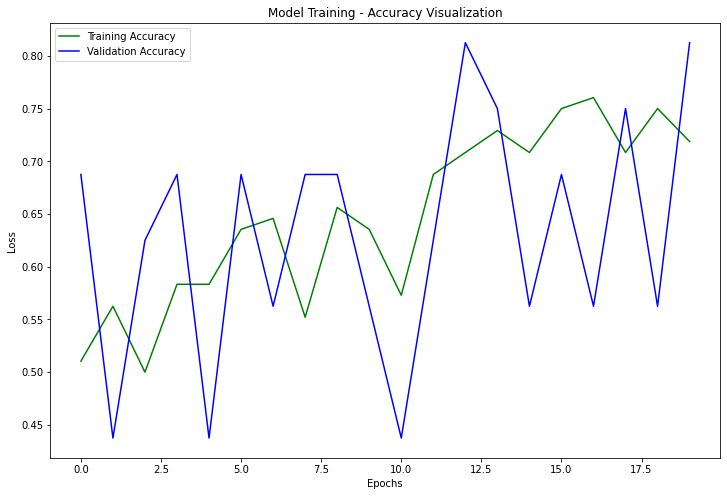

In [12]:
# plot accuracies
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, N_EPOCHS), train_accuracy, 'g-', label='Training Accuracy')
plt.plot(np.arange(0, N_EPOCHS), valid_accuracy, 'b-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training - Accuracy Visualization')
plt.legend(loc='best')
plt.show()

### Exercise 5: Visualize the weights (0.5 points)
The model's weights in a particular layer that the MLP has learned can be found in `model_name.layer_name.weight.data`. Plot the weights of the 16 ReLU units as 2D images.

### Solution 5

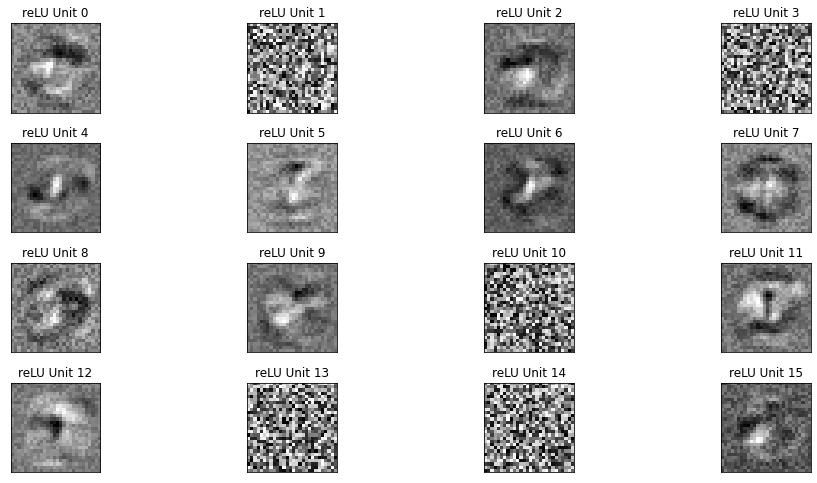

In [13]:
reluUnits = model.fc1.weight.data.numpy()
plt.figure(figsize=(14,7))
for i in range(reluUnits.shape[0]):
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.imshow(reluUnits[i].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("reLU Unit {}".format(i))
    plt.xticks([])
    plt.yticks([])

### Exercise 6: Convolution with hand-made kernels (1 point)
In convolutional neural networks we use a mathematical operator between two functions $f$ and $g$ called [*convolution*](https://en.wikipedia.org/wiki/Convolution). In terms of images, one could intuitively think of $f$ as an image, and $g$ as a filter kernel (i.e., a receptive field). For images we need to use 2D convolution: 

$$f(x, y) \ast g(x, y) = \sum^N_{i=-N}\sum^N_{j=-N} f(x, y)g(x-i, y-j)$$

Intuitively, the kernel $g$ is applied on all spatial locations of $f$. You could think of $g$ as having weights that represent how it singles out local input. Usually there are various of these filter kernels $g$, scanning the image for many possible features. 

In this exercise you will perform a simple convolution on one image.
1. Make four $3 \times 3$ kernels. They should represent horizontal, vertical, and the two diagonal line feature detectors.
1. Plot these kernels.
1. Apply the kernels to the image, e.g. by using `convolved2d` from `scipy`.
1. Plot the resulting feature activity map for each of the kernels. 

### Solution 6

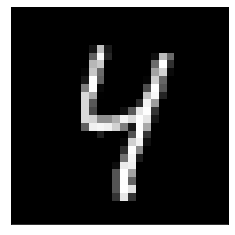

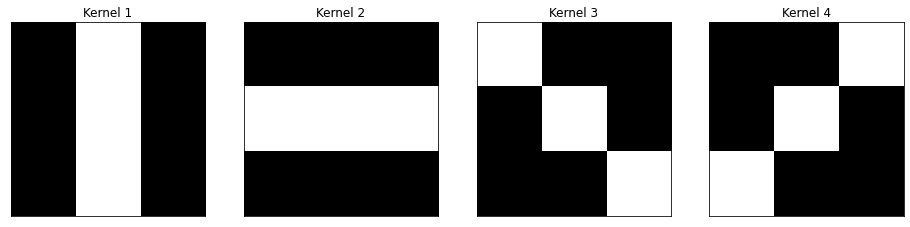

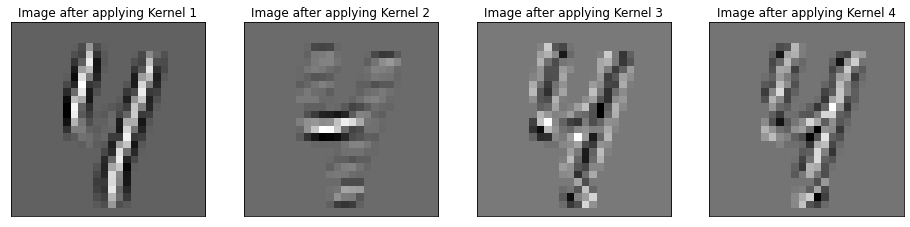

In [14]:
# The image
image = example_data[2][0].reshape((28, 28))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(image, cmap="gray")
plt.xticks([])
plt.yticks([])
 
# 1. Create kernels
kernel_vert = [ [-1.0,  2.0, -1.0],
                [-1.0,  2.0, -1.0],
                [-1.0,  2.0, -1.0] ]
 
kernel_hori = [ [-1.0, -1.0, -1.0],
                [ 2.0,  2.0,  2.0],
                [-1.0, -1.0, -1.0] ]
 
kernel_diag1 = [ [ 2.0, -1.0, -1.0],
                 [-1.0,  2.0, -1.0],
                 [-1.0, -1.0,  2.0] ]
 
kernel_diag2 = [ [-1.0, -1.0,  2.0],
                 [-1.0,  2.0, -1.0],
                 [ 2.0, -1.0, -1.0] ]
 
kernels = [kernel_vert, kernel_hori, kernel_diag1, kernel_diag2]
 
# 2. Plot kernels
plt.figure(figsize=(16,16))
for i in range(len(kernels)):
    plt.subplot(1,4,i+1)
    plt.imshow(kernels[i], cmap='gray', interpolation='none')
    plt.title("Kernel {}".format(i+1))
    plt.xticks([])
    plt.yticks([])
plt.show()
 
# 3. Convolve the image with the kernels
conv_images = []
for k in kernels:
    conv_images.append(ss.convolve2d(image, k, mode='valid'))

# 4. Plot the activity maps
plt.figure(figsize=(16,16))
for i in range(len(conv_images)):
    plt.subplot(1,4,i+1)
    plt.imshow(conv_images[i], cmap='gray', interpolation='none')
    plt.title("Image after applying Kernel {}".format(i+1))
    plt.xticks([])
    plt.yticks([])
plt.show()

### Exercise 7: Setup a CNN (1 points)
As a second model, setup a CNN with:
1. One convolutional layer and one linear (i.e., fully connected) weight layer.
1. In the convolutional layer, use $8$ kernels of size $3\times3$ and stride $1$.
1. ReLU units in the hidden layer.
1. Max pooling with kernels of size $2\times2$ and stride $2$.

### Solution 7

In [15]:
class CNN(nn.Module):
    """
    PyTorch Implementation of Convolutional Neural Network (CNN)
    """
    def __init__(self, in_size, out_size):
        """
        @description:
            Initial Network Setup
        @arguments:
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_size, 8, 3)
        self.maxp1 = nn.MaxPool2d(2, 2)
        self.n_hidden = 8*13*13 # output_width/height=(28-3+1)/2 (conv2d + maxpool2d)
        self.fc1 = nn.Linear(self.n_hidden, out_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """
        @description:
            Feed-forward function
        @arguments:
            x (tensor) - input tensor
        @returns:
            y (tensor) - output tensor
        """
        x = self.relu(self.maxp1(self.conv1(x))) # convolutional layer
        x = x.view(-1, self.n_hidden)
        y = self.relu(self.fc1(x)) # Fully connected layer
        return y

### Exercise 8: Train the CNN (1 point) 
Train the CNN using the MNIST dataset:
1. As optimizer use SGD with a learning rate of 0.001 and momentum of 0.9.
1. As loss function use the cross-entropy loss.
1. Train the CNN in 20 epochs.
1. Plot the training and validation losses as a function of epochs.
1. Plot the training and validation accuracies as a function of epochs.

### Solution 8

In [16]:
# define model
model = CNN(1, OUT_SIZE)
# define optimizer
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
# define criterion (loss function)
criterion = nn.CrossEntropyLoss()

In [17]:
# train model
model, train_loss, valid_loss, train_accuracy, valid_accuracy = train_model(model, train_data, valid_data, 
                                                                            optimizer, criterion, N_EPOCHS)

epoch 1: train_loss: 1.105 | train_acc: 0.677 | val_loss: 0.802 | val_acc: 0.875
epoch 2: train_loss: 0.941 | train_acc: 0.677 | val_loss: 0.679 | val_acc: 0.812
epoch 3: train_loss: 0.740 | train_acc: 0.760 | val_loss: 0.604 | val_acc: 0.750
epoch 4: train_loss: 0.874 | train_acc: 0.667 | val_loss: 0.524 | val_acc: 0.812
epoch 5: train_loss: 0.539 | train_acc: 0.833 | val_loss: 0.491 | val_acc: 0.812
epoch 6: train_loss: 0.645 | train_acc: 0.760 | val_loss: 1.307 | val_acc: 0.562
epoch 7: train_loss: 0.921 | train_acc: 0.667 | val_loss: 0.402 | val_acc: 0.875
epoch 8: train_loss: 0.759 | train_acc: 0.708 | val_loss: 0.647 | val_acc: 0.812
epoch 9: train_loss: 0.781 | train_acc: 0.688 | val_loss: 0.394 | val_acc: 0.875
epoch 10: train_loss: 0.583 | train_acc: 0.781 | val_loss: 0.803 | val_acc: 0.688
epoch 11: train_loss: 0.784 | train_acc: 0.729 | val_loss: 0.991 | val_acc: 0.625
epoch 12: train_loss: 0.883 | train_acc: 0.667 | val_loss: 0.609 | val_acc: 0.750
epoch 13: train_loss: 0.5

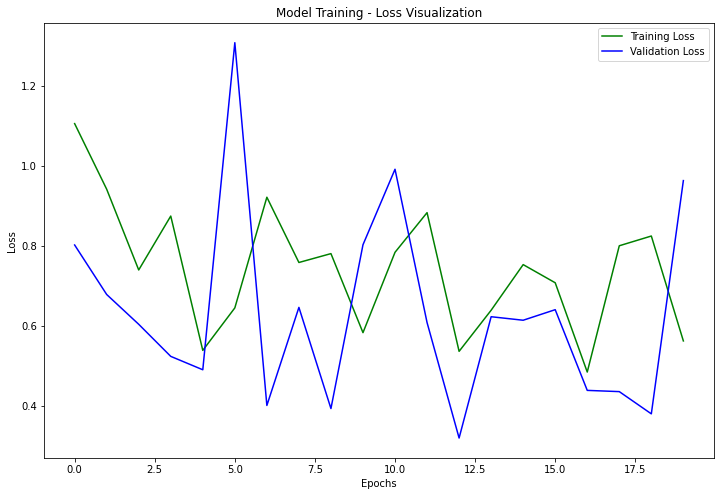

In [18]:
# plot losses
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, N_EPOCHS), train_loss, 'g-', label='Training Loss')
plt.plot(np.arange(0, N_EPOCHS), valid_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training - Loss Visualization')
plt.legend(loc='best')
plt.show()

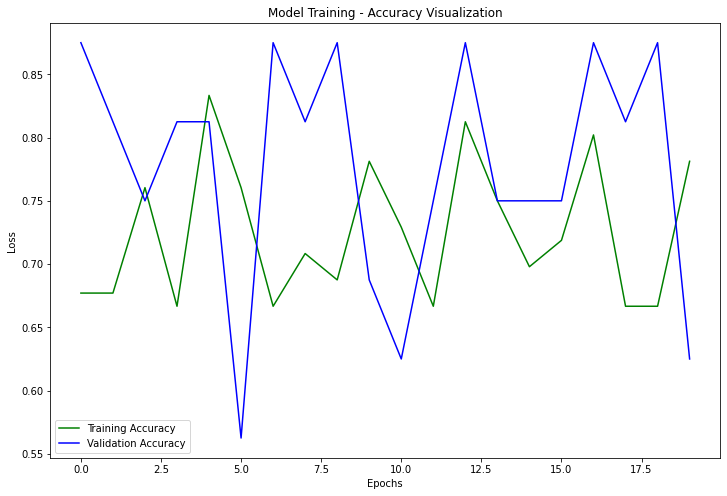

In [19]:
# plot accuracies
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, N_EPOCHS), train_accuracy, 'g-', label='Training Accuracy')
plt.plot(np.arange(0, N_EPOCHS), valid_accuracy, 'b-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training - Accuracy Visualization')
plt.legend(loc='best')
plt.show()

### Exercise 9: Visualize the weights (0.5 points)
The model's weights in the convolutional layer that the CNN has learned can be found in `model_name.layer_name.weight.data`. Plot the kernels as images.

Showing what the first weight layer learns is easy. But this task becomes more difficult in higher layers, and is a current area of research. Here is highly recommended reading on what convolutional neural networks learn: 

[Feature visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

[The building blocks of interpretability](https://distill.pub/2018/building-blocks/)

### Solution 9

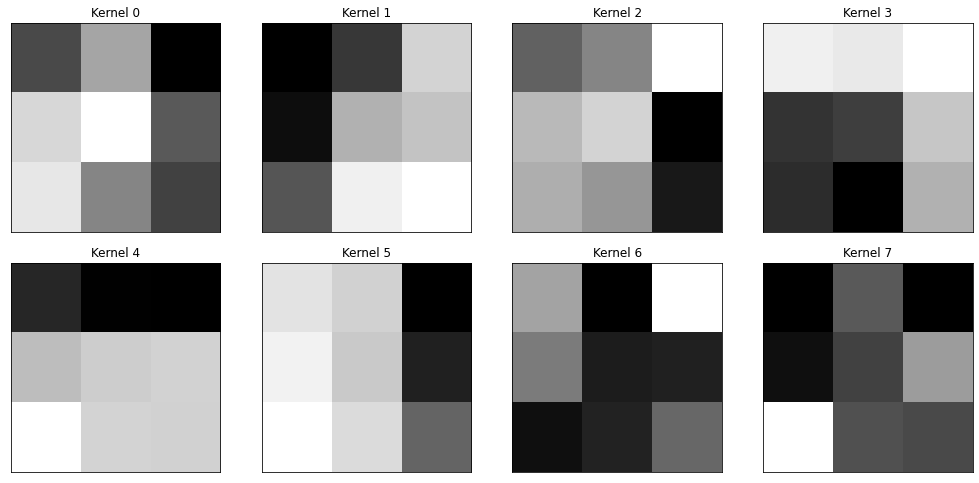

In [20]:
conv_wts = model.conv1.weight.data.numpy()
plt.figure(figsize=(14,7))
for i in range(conv_wts.shape[0]):
    plt.subplot(2,4,i+1)
    plt.tight_layout()
    plt.imshow(conv_wts[i].reshape(3,3), cmap='gray', interpolation='none')
    plt.title("Kernel {}".format(i))
    plt.xticks([])
    plt.yticks([])

### Exercise 10: Interpretation (2 points)
1. Which of the two models performed better for classifying MNIST digits in this example? Compare speed of training and test set accuracy. 
1. The main difference of the models is the type of the first layer. Why would a convolutional layer lead to the better success here? 
1. Explain one argument why the convolution operation is biologically plausible and one argument why it is biologically implausible. 

### Solution 10
1. 

2. 

3. 